In [ ]:
import tensorflow as tf

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %%bash
# # To generate GIFs
# pip install imageio
# pip install git+https://github.com/tensorflow/docs

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import cv2
from glob import glob
from torch.utils.data import Dataset, DataLoader


import torch
import pandas as pd
from skimage import io, transform
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from  torchvision import utils as vutils

from IPython import display
from torchvision.transforms import ToPILImage
from torchvision.transforms import RandomHorizontalFlip,RandomCrop,ToTensor,Resize,RandomRotation
import seaborn as sns
import random
import math

**Loading dataset**

In [ ]:
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()


In [ ]:
class CovidDataset(Dataset):
    """Covid CT dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # self.label_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        ## you can apply custom transformation on the image for data augmentation
        self.transform = transform

    def __len__(self):
        return len(self.label_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.label_data.iloc[idx, 0])
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)
        p = self.label_data.iloc[idx, 1]
        subject_num = self.label_data.iloc[idx, 2]
        sample = {'image': image,'img_name':img_name}

        # should be only applied on image, not percentage or subject #
        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

In [ ]:
class MaskDataset(Dataset):
    """facial mask dataset."""

    def __init__(self, root_dir, de_root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.de_root_dir = de_root_dir
        self.transform = transform
        self.image_list = []
        self.true_list = []
        for i in range(200):
          s = str(i)
          if len(s)==1:
            s = "000"+s
          elif len(s)==2:
            s = "00"+s
          else:
            s = "0"+s 
          filename = self.root_dir+s+".png"       
          self.image_list.append(filename)
          filename = self.de_root_dir+str(i)+".png"
          self.true_list.append(filename)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_list[idx]
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)
        img_name_de = self.true_list[idx]
        image_de = io.imread(img_name_de)
        image_de = cv2.cvtColor(image_de, cv2.COLOR_BGRA2BGR)
        image_de = torchvision.transforms.functional.to_tensor(image_de)
        sample = {'image': image_de, 'img_name':img_name, 'label': image}
        if self.transform:
            sample['image'] = self.transform(sample['image'])       
            sample['label'] = self.transform(sample['label']) 
            sample['image'] = sample['image'].numpy().transpose(1,2,0)
            sample['label'] = sample['label'].numpy().transpose(1,2,0)
        
        # sample['image'] = torch.reshape(sample['image'],(256,256,3))           
        # sample['label'] = torch.reshape(sample['label'],(256,256,3)) 
        return sample

In [ ]:
class deMaskDataset(Dataset):
    """facial mask dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = []
        for i in range(200):
          s = str(i)
          # if len(s)==1:
          #   s = "000"+s
          # elif len(s)==2:
          #   s = "00"+s
          # else:
          #   s = "0"+s 
          filename = self.root_dir+s+".png"       
          self.image_list.append(filename)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_list[idx]
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)
        sample = {'image': image, 'img_name':img_name}
        if self.transform:
            sample['image'] = self.transform(sample['image'])       
            sample['image'] = sample['image'].numpy().transpose(1,2,0)
        return sample

In [ ]:
groundDataset_train_val = MaskDataset(
                                    root_dir='drive/MyDrive/DL_final/without_mask/seed',
                                    de_root_dir='drive/MyDrive/DL_final/de-mask/fig'
                                    , transform = transforms.Compose([
                                              ToPILImage(),
                                              # RandomRotation(90),
                                              # RandomHorizontalFlip(p = 0.8),
                                              # RandomCrop(224),  
                                              Resize(256),                                          
                                              ToTensor()
                                              
                                          ])
                                    )
# deMaskDataset_train_val = deMaskDataset(
#                                     root_dir='drive/MyDrive/DL_final/de-mask/fig'
#                                     , transform = transforms.Compose([
#                                               ToPILImage(),
#                                               # RandomRotation(90),
#                                               # RandomHorizontalFlip(p = 0.8),
#                                               # RandomCrop(224),  
#                                               Resize(256),                                          
#                                               ToTensor()
                                              
#                                           ])
#                                     )

In [ ]:
MaskDataset_train_val = deMaskDataset(
                                    root_dir='drive/MyDrive/DL_final/mask/mask'
                                    , transform = transforms.Compose([
                                              ToPILImage(),
                                              # RandomRotation(90),
                                              # RandomHorizontalFlip(p = 0.8),
                                              # RandomCrop(224),  
                                              Resize(256),                                          
                                              ToTensor()                                             
                                          ])
                                    )

In [ ]:
# train_images = []
# for i in range(len(deMaskDataset_train_val)):
#   deMaskDataset_train_val[i]['label'] = groundDataset_train_val[i]['image']
#   # train_images.append(image_copy)

In [ ]:
# def readImage(path,image_size=(256,256)):
#     img = np.asarray(PIL.Image.open(path).resize(image_size))
#     # img - 127.5 / 127.5 ==> compress between [-1,1]
#     img = ((img - 127.5) / 127.5).astype("float32")
#     return img

In [ ]:
groundDataset_train_val[0]['image'].T.shape

(3, 256, 256)

Have a Test

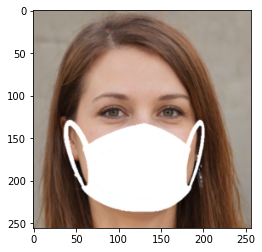

In [ ]:


plt.imshow(groundDataset_train_val[0]['image'])
plt.show()

In [ ]:
groundDataset_train_val[3]['label'].transpose(1,2,0).shape

(256, 3, 256)

In [ ]:
# BATCH_SIZE = 128
# #STEPS_PER_EPOCH = len(image_paths) // BATCH_SIZE
# #1582 steps are too many steps. Let's just train for 500 steps.
# STEPS_PER_EPOCH = 500
# print("Steps per epochh are",STEPS_PER_EPOCH)
# def dataGenerator(batch_size):
#     while True:
#         paths = random.choices(all_images,k=batch_size)
#         batch = []
#         for p in paths:
#             batch.append(readImage(p))
        
#         yield np.asarray(batch)

# dataGen = dataGenerator(BATCH_SIZE)
# print(next(dataGen).shape)

In [ ]:
# !unzip "/gdrive/MyDrive/Mask Classification.zip"

In [ ]:
# train_images = cv2.imread(train_images_path + "/*.png")

In [ ]:
#train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
#train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
# BUFFER_SIZE = 60000
# # BATCH_SIZE = 256
# BATCH_SIZE = 128

In [ ]:
# Batch and shuffle the data
# train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
from sklearn.model_selection import train_test_split
train_size = int(0.8 * len(groundDataset_train_val))
val_size = len(groundDataset_train_val) - train_size
print(train_size, val_size)
train_dataset, val_dataset = torch.utils.data.random_split(groundDataset_train_val, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)

## test set
# test_dataloader = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)
# train_dataloader,val_dataloader,test_dataloader = rand_split(groundDataset_train_val)

160 40


**Set model**

**Generator**

In [ ]:
# deMaskDataset_train_val[0]['image'].shape

In [ ]:
def generator_mask_model():
    model = tf.keras.Sequential()
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(16, (5, 5), padding='same', use_bias=False,input_shape=[256,256,3]))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5),  padding='same', use_bias=False))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), padding='same', use_bias=False))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(32, (5, 5),  padding='same', use_bias=False))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.LeakyReLU())
    return model

In [ ]:
mask_generator = generator_mask_model()
# 

In [ ]:
mask_g = mask_generator(MaskDataset_train_val[0]['image'].reshape(1,256,256,3), training=False) # try

In [ ]:
fig_g = mask_generator(groundDataset_train_val[0]['image'].reshape(1,256,256,3), training=False) #try

In [ ]:
mask_generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (1, 256, 256, 3)         12        
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (1, 256, 256, 16)        1200      
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (1, 256, 256, 16)        64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (1, 128, 128, 16)        0         
 )                                                               
                                                                 
 leaky_re_lu (LeakyReLU)     (1, 128, 128, 16)         0

In [ ]:
a = np.zeros(16*16*16 ).reshape(16,16,16)
b = np.zeros(16*16*16 ).reshape(16,16,16)
np.dstack((a,b)).shape

(16, 16, 32)

In [ ]:
def mask_attention_model(mask_g,fig_g):
    alpha = 0.01
    model1 = tf.keras.Sequential()
    model1.add(layers.Conv1D(16,5,padding = 'same',input_shape = [16, 16, 32]))
    K = model1(mask_g).numpy().reshape(16*16,16)
    model2 = tf.keras.Sequential()
    model2.add(layers.Conv1D(16,3,padding = 'same',input_shape = [16, 16, 32]))
    Q = model1(mask_g).numpy().reshape(16*16,16)
    S_nom = np.exp(np.dot(K, Q.T))
    S_denom = sum(S_nom)
    S = S_nom/S_denom
    model3 = tf.keras.Sequential()
    model3.add(layers.Conv1D(16,5,padding = 'same',input_shape = [16, 16, 32]))
    V = model3(fig_g).numpy().reshape(16*16,16)
    A = np.dot(V.T,S.T).T.reshape(16,16,-1) # zero-pad
    a = np.zeros(16*16*16 ).reshape(16,16,16)
    A = alpha * np.dstack((A,a))+mask_g
    return A

In [ ]:
m = mask_attention_model(mask_g,fig_g) # try
# m

In [ ]:
m.shape

TensorShape([1, 16, 16, 32])

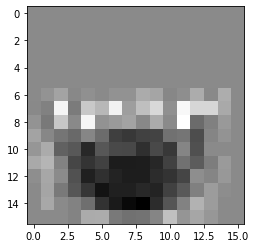

In [ ]:
plt.imshow(m[0,:,:,-1]*255, cmap='gray') # try

In [ ]:
def make_generator_model(x,y,training = False):
    model = tf.keras.Sequential()
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(16, (5, 5), padding='same', use_bias=False,input_shape=[256,256,3]))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.LeakyReLU())
    x1 = model(x,training = training) 
    x1_mask = model(y, training = training) # The corresponding mask pic

    model1 = tf.keras.Sequential()
    model1.add(layers.Conv2DTranspose(32, (5, 5),  padding='same', use_bias=False))
    model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model1.add(layers.LeakyReLU())
    x2 = model1(x1,training = training)
    x2_mask = model1(x1,training = training)  # same

    model2 = tf.keras.Sequential()
    model2.add(layers.Conv2DTranspose(64, (5, 5), padding='same', use_bias=False))
    model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model2.add(layers.LeakyReLU())
    x3 = model2(x2,training = training)
    x3_mask = model2(x2,training = training)  # same
    res_mam_1 = mask_attention_model(x3_mask, x3)

    model3 = tf.keras.Sequential()
    model3.add(layers.Conv2DTranspose(32, (5, 5),  padding='same', use_bias=False))
    model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model3.add(layers.LeakyReLU())
    x4 = model3(x3,training = training)
    x4_mask = model2(x3,training = training)  # same
    res_mam_2 = mask_attention_model(x4_mask, x4)


    model4 = tf.keras.Sequential()
    model4.add(layers.Conv2DTranspose(128, (5, 5),  padding='same', use_bias=False))
    model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model4.add(layers.LeakyReLU())
    x5 = model4(x4,training = training)

    l = layers.Conv2DTranspose(32, (5, 5), strides=(2,2),  padding='same', use_bias=False)
    x6 = l(x5,training = training)
    x6 = layers.Concatenate()([res_mam_2, x6])

    l = layers.Conv2DTranspose(64, (5, 5), strides=(2,2),  padding='same', use_bias=False)
    x7 = l(x6,training = training)
    x7 = layers.Concatenate()([res_mam_1, x7])
    
    l = layers.LeakyReLU()
    x8 = l(x7,training = training)

    l = layers.Conv2DTranspose(32, (5, 5), strides=(2,2),  padding='same', use_bias=False)
    x9 = l(x8,training = training)
    x9 = layers.Concatenate()([x2, x9])
    l = layers.Conv2DTranspose(16, (5, 5), strides=(2,2),  padding='same', use_bias=False)
    x10 = l(x9,training = training)
    l = layers.LeakyReLU()
    x11 = l(x10,training = training)
    x11 = layers.Concatenate()([x1, x11])
    l = layers.Conv2DTranspose(3, (5, 5), strides=(2,2),  padding='same', use_bias=False, activation='tanh')
    x = l(x11,training = training)
    return x


In [ ]:
generator = make_generator_model(groundDataset_train_val[0]['image'].reshape(1,256,256,3), MaskDataset_train_val[0]['image'].reshape(1,256,256,3), training=False)

ValueError: ignored

In [ ]:
plt.imshow(generator[0,:,:,0]*255, cmap='gray') 

In [ ]:
generator = make_generator_model()

# noise = tf.random.normal([1, 100])
generated_image = generator(groundDataset_train_val[0]['image'].reshape(1,256,256,3), training=False) # try

plt.imshow(generated_image[0,:,:,0]*255, cmap='gray') 

**Discriminator**

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[256, 256, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0002057]], shape=(1, 1), dtype=float32)


**Definition of Loss function and optimation**

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

**Loss of Discrimination**

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

**Loss of Generator**

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

**Optimizer**

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

**Keep saving point**

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**Definition of training loop**

In [ ]:
EPOCHS = 50
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = val_dataset[0]['image'].reshape(1,256,256,3)

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,groundtrue):
    # noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      #modify
      generated_images = generator(images.numpy(), training=True)

      real_output = discriminator(groundtrue.numpy(), training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for batch_idx, sample_batched in enumerate(train_dataloader):
      # modify
      image,groundtrue = sample_batched['image'], sample_batched['label']
      train_step(image,groundtrue)
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and saving pictures**

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(5, 5))

  for i in range(predictions.shape[0]):
      # plt.subplot(256, 256, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

**Training model**

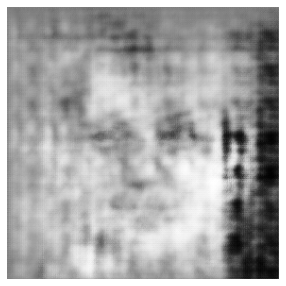

In [ ]:
train(train_dataloader, 70)

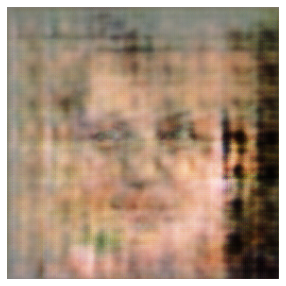

In [ ]:
predictions = generator(val_dataset[0]['image'].reshape(1,256,256,3), training=False) # modify

fig = plt.figure(figsize=(5, 5))

for i in range(predictions.shape[0]):
    # plt.subplot(256, 256, i+1)
    plt.imshow(predictions[i, :, :, :], cmap='gray')
    plt.axis('off')

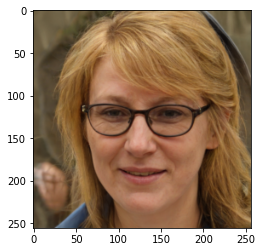

In [ ]:
plt.imshow(val_dataset[0]['label'])
plt.show()

**Restoring the latest saving point**

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

**Set GIF**

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

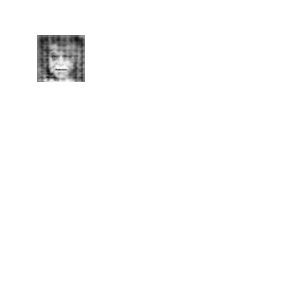

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs


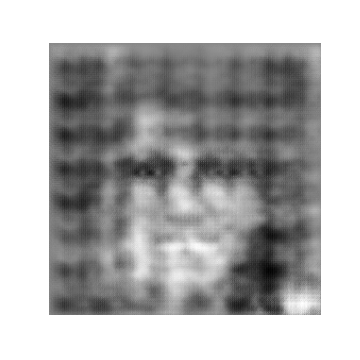

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)